In [118]:
import os
desktop_dir = os.path.expanduser('~/Desktop/math_results')
X_features_path = os.path.join(desktop_dir, 'X_features.npy')
y_groups_path = os.path.join(desktop_dir, 'y_labels.npy')
y_tasks_path = os.path.join(desktop_dir, 'y_tasks.npy')
groups_path = os.path.join(desktop_dir, 'subject_groups.npy')

In [119]:
# make nn deterministic
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [120]:
import numpy as np

def filter_task_data(X, y_group, y_task, groups, task_id):
    """Returns only the data and labels associated with a specific task_id."""
    mask = (y_task == task_id)
    return X[mask], y_group[mask], groups[mask]

def average_by_subject(X_subset, y_subset, groups_subset):
    """Averages multiple runs/trials for each unique subject."""
    X_avg, y_avg = [], []
    unique_subs = np.unique(groups_subset)
    
    for sub in unique_subs:
        sub_indices = np.where(groups_subset == sub)[0]
        # Mean across features for this participant
        X_avg.append(np.mean(X_subset[sub_indices], axis=0))
        # Keep the label (TD or MLD)
        y_avg.append(y_subset[sub_indices[0]])
        
    return np.array(X_avg), np.array(y_avg)

In [121]:
# 1. Load your actual data
X = np.load(X_features_path) 
y_groups = np.load(y_groups_path)
y_task = np.load(y_tasks_path)
groups = np.load(groups_path)

# MLP for All Tasks

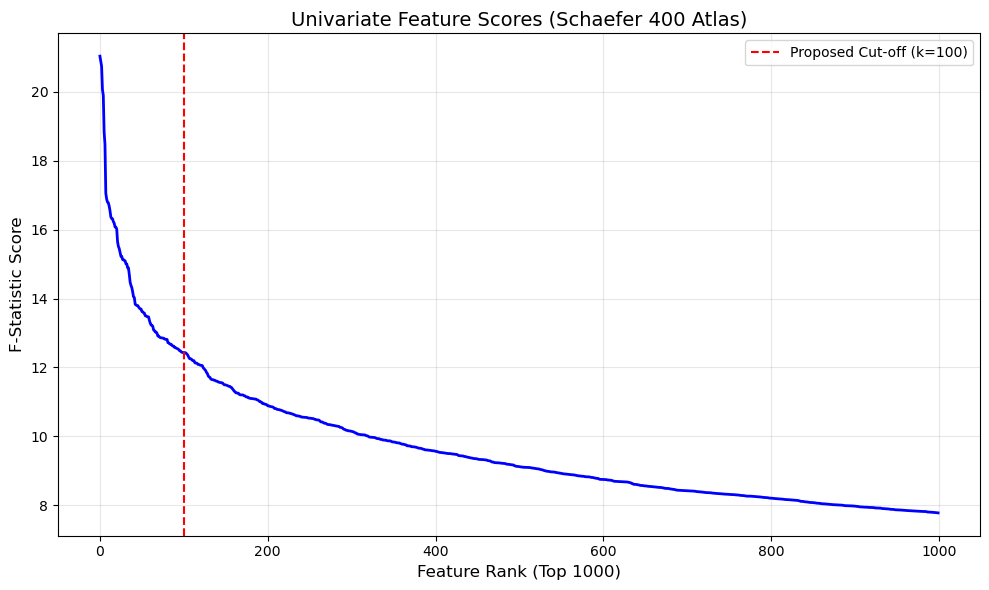

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif


X_avg, y_avg = average_by_subject(X, y_groups, groups)


# 2. Calculate F-statistic scores for all 79,800 features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_avg, y_avg)
scores = selector.scores_

# 3. Sort scores in descending order
sorted_scores = np.sort(scores)[::-1]

# 4. Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_scores[:1000], color='blue', linewidth=2) # Look at top 1000
plt.axvline(x=100, color='red', linestyle='--', label='Proposed Cut-off (k=100)')

plt.title('Univariate Feature Scores (Schaefer 400 Atlas)', fontsize=14)
plt.xlabel('Feature Rank (Top 1000)', fontsize=12)
plt.ylabel('F-Statistic Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [123]:
import torch
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# 1. First Filter: Select top 100 statistically significant connections
selector = SelectKBest(score_func=f_classif, k=100)
X_reduced = selector.fit_transform(X_avg, y_avg)
selected_indices = selector.get_support(indices=True)

# 2. Scale the data (Lasso/MLPs require this!)
scaler = StandardScaler()
X_final = scaler.fit_transform(X_reduced)

# 3. Convert to Tensors for PyTorch
X_tensor = torch.tensor(X_final, dtype=torch.float32)
y_tensor = torch.tensor(y_avg, dtype=torch.float32).view(-1, 1)

In [124]:
import torch.nn as nn
import torch.optim as optim
class LassoBrainMLP(nn.Module):
    def __init__(self):
        super(LassoBrainMLP, self).__init__()
        # Input is now 100
        self.layer1 = nn.Linear(100, 32) 
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        return self.sigmoid(self.output(x))
    
model = LassoBrainMLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
l1_lambda = 0.005 # Increase this to make the map "sparser

In [125]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import torch
import numpy as np

loo = LeaveOneOut()
all_test_preds = []
all_test_labels = []
all_test_probs = []

print(f"Starting LOOCV with LASSO regularization...")

for train_idx, test_idx in loo.split(X_final):
    # 1. Split Data
    X_train, X_test = X_final[train_idx], X_final[test_idx]
    y_train, y_test = y_avg[train_idx], y_avg[test_idx]

    # 2. Convert to Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)

    # 3. Initialize fresh model and optimizer for THIS fold
    model = LassoBrainMLP() # Your 100 -> 32 -> 1 model
    criterion = torch.nn.BCELoss() # The BCE Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    l1_lambda = 0.005 

    # 4. Train on the 29 participants
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        
        # Calculate BCE Loss
        bce_loss = criterion(outputs, y_train_t)
        
        # Add LASSO Penalty
        l1_penalty = torch.norm(model.layer1.weight, 1)
        total_loss = bce_loss + (l1_lambda * l1_penalty)
        
        total_loss.backward()
        optimizer.step()

    # 5. Test on the 1 participant left out
    model.eval()
    with torch.no_grad():
        test_prob = model(X_test_t)
        all_test_probs.append(test_prob)
        # Convert probability to 0 or 1
        test_pred = 1.0 if test_prob.item() > 0.5 else 0.0
        
        all_test_preds.append(test_pred)
        all_test_labels.append(y_test[0])

# 6. Final Report
final_acc = accuracy_score(all_test_labels, all_test_preds)
print(f"\nFinal LOOCV Accuracy: {final_acc * 100:.2f}%")

Starting LOOCV with LASSO regularization...

Final LOOCV Accuracy: 70.00%


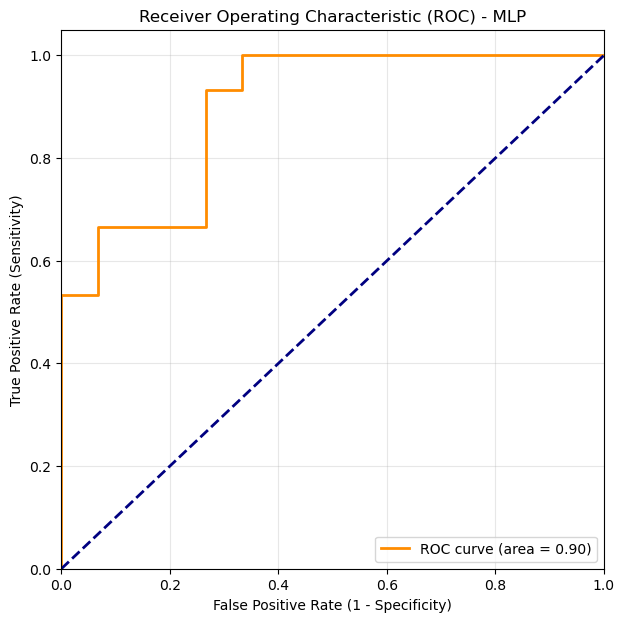

In [126]:
# 1. Convert lists to numpy arrays first
labels_array = np.array(all_test_labels)
probs_array = np.array(all_test_probs)

# 2. Flatten them to ensure they are 1D (removes that extra dimension)
labels_flat = labels_array.flatten()
probs_flat = probs_array.flatten()

from sklearn.metrics import roc_curve, auc
# After the loop finishes:
fpr, tpr, thresholds = roc_curve(labels_flat, probs_flat)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) - MLP')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Detailed Classification Report:
                          precision    recall  f1-score   support

     Typical Development       0.69      0.73      0.71        15
Math Learning Difficulty       0.71      0.67      0.69        15

                accuracy                           0.70        30
               macro avg       0.70      0.70      0.70        30
            weighted avg       0.70      0.70      0.70        30



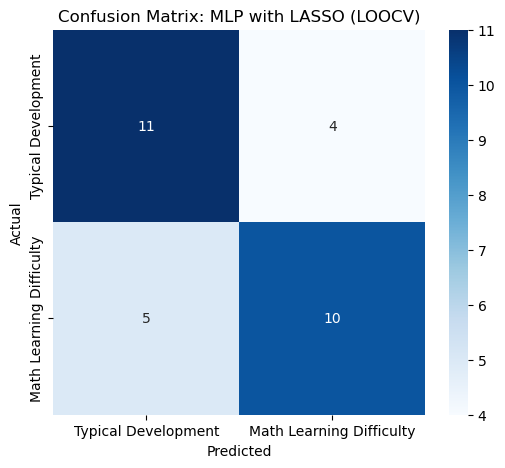

In [127]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Classification Report (Precision, Recall, F1)
# 0 = TD, 1 = MLD
target_names = ['Typical Development', 'Math Learning Difficulty']
print("\nDetailed Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

# 2. Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# 3. Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: MLP with LASSO (LOOCV)')
plt.show()

In [128]:
model.eval()
# Get the absolute sum of weights for each of the 100 features
# This tells us how much the model "trusts" each brain connection
feature_weights = torch.abs(model.layer1.weight).sum(dim=0).detach().numpy()

# Get indices of features with non-zero weights (the 'winners')
threshold = 1e-4 
winning_meta_indices = np.where(feature_weights > threshold)[0]
winning_raw_indices = selected_indices[winning_meta_indices]

print(f"{len(winning_raw_indices)} connections survived.")

100 connections survived.


In [129]:
from nilearn import datasets
def get_roi_names(index, n_rois=400):
    """Converts a vector index back to ROI pairs (Schaefer 400)."""
    # Create an empty upper triangle matrix
    tri_indices = np.triu_indices(n_rois, k=1)
    roi_a_idx = tri_indices[0][index]
    roi_b_idx = tri_indices[1][index]
    return roi_a_idx, roi_b_idx

# 3. Get the Top 10 Indices
# argsort gives indices of features from smallest to largest weight
# [-10:] takes the last 10 (the largest), and [::-1] puts them in descending order
top_10_meta_indices = np.argsort(feature_weights)[-10:][::-1]

# Map these meta-indices (0-99) back to the original connectivity indices (0-79799)
# Assuming 'selected_indices' is the array from your SelectKBest step
top_10_raw_indices = selected_indices[top_10_meta_indices]

# 4. Print and Store Results
print(f"--- Top 10 Connectivity Fingerprints ---")
top_connections_info = []
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
labels = atlas.labels
for i, raw_idx in enumerate(top_10_raw_indices):
    roi_a_idx, roi_b_idx = get_roi_names(raw_idx)
    
    label_a = (labels[roi_a_idx])
    label_b = (labels[roi_b_idx])
    score = feature_weights[top_10_meta_indices[i]]
    
    print(f"Rank {i+1}: Score {score:.4f} | {label_a} <-> {label_b}")
    
    top_connections_info.append({
        'rank': i+1,
        'score': score,
        'roi_a': label_a,
        'roi_b': label_b,
        'indices': (roi_a_idx, roi_b_idx)
    })

--- Top 10 Connectivity Fingerprints ---
[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018
Rank 1: Score 1.7848 | 7Networks_LH_Cont_PFCl_5 <-> 7Networks_RH_Limbic_TempPole_5
Rank 2: Score 1.6114 | 7Networks_LH_Vis_25 <-> 7Networks_RH_Cont_Par_2
Rank 3: Score 1.5851 | 7Networks_RH_SomMot_17 <-> 7Networks_RH_DorsAttn_FEF_1
Rank 4: Score 0.9135 | 7Networks_LH_Limbic_TempPole_5 <-> 7Networks_LH_Cont_PFCl_1
Rank 5: Score 0.8552 | 7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Post_14
Rank 6: Score 0.5468 | 7Networks_LH_Default_Temp_8 <-> 7Networks_RH_DorsAttn_Post_4
Rank 7: Score 0.5349 | 7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8
Rank 8: Score 0.3380 | 7Networks_LH_Vis_27 <-> 7Networks_RH_DorsAttn_FEF_3
Rank 9: Score 0.3058 | 7Networks_LH_DorsAttn_Post_6 <-> 7Networks_LH_Default_pCunPCC_3
Rank 10: Score 0.2959 | 7Networks_LH_SomMot_16 <-> 7Networks_LH_Cont_PFCl_5


# MLP for Mult Tasks

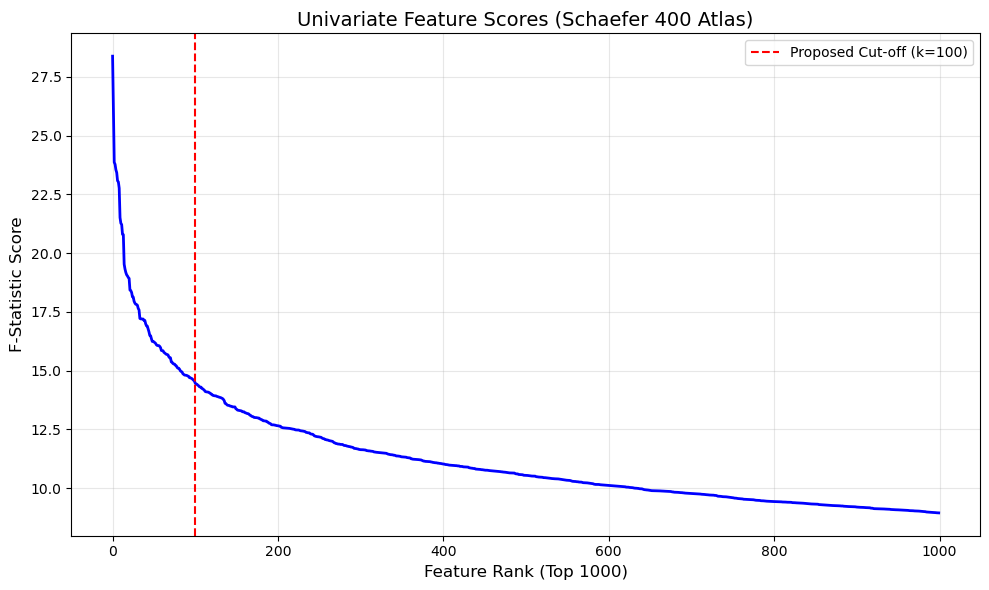

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Load your actual data
X_m, y_m, g_m = filter_task_data(X, y_groups, y_task, groups, task_id=1)
X_avg_m, y_avg_m = average_by_subject(X_m, y_m, g_m)


# 2. Calculate F-statistic scores for all 79,800 features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_avg_m, y_avg_m)
scores = selector.scores_

# 3. Sort scores in descending order
sorted_scores = np.sort(scores)[::-1]

# 4. Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_scores[:1000], color='blue', linewidth=2) # Look at top 1000
plt.axvline(x=100, color='red', linestyle='--', label='Proposed Cut-off (k=100)')

plt.title('Univariate Feature Scores (Schaefer 400 Atlas)', fontsize=14)
plt.xlabel('Feature Rank (Top 1000)', fontsize=12)
plt.ylabel('F-Statistic Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [131]:
import torch
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# 1. First Filter: Select top 100 statistically significant connections
selector = SelectKBest(score_func=f_classif, k=100)
X_reduced_m = selector.fit_transform(X_avg_m, y_avg_m)
selected_indices = selector.get_support(indices=True)

# 2. Scale the data (Lasso/MLPs require this!)
scaler = StandardScaler()
X_final_m = scaler.fit_transform(X_reduced_m)

# 3. Convert to Tensors for PyTorch
# X_tensor_m = torch.tensor(X_final, dtype=torch.float32)
# y_tensor_m = torch.tensor(y_avg_m, dtype=torch.float32).view(-1, 1)

In [132]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import torch
import numpy as np

loo = LeaveOneOut()
all_test_preds = []
all_test_labels = []
all_test_probs = []

print(f"Starting LOOCV with LASSO regularization...")

for train_idx, test_idx in loo.split(X_final):
    # 1. Split Data
    X_train, X_test = X_final_m[train_idx], X_final[test_idx]
    y_train, y_test = y_avg_m[train_idx], y_avg[test_idx]

    # 2. Convert to Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)

    # 3. Initialize fresh model and optimizer for THIS fold
    model = LassoBrainMLP() # Your 100 -> 32 -> 1 model
    criterion = torch.nn.BCELoss() # The BCE Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    l1_lambda = 0.005 

    # 4. Train on the 29 participants
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        
        # Calculate BCE Loss
        bce_loss = criterion(outputs, y_train_t)
        
        # Add LASSO Penalty
        l1_penalty = torch.norm(model.layer1.weight, 1)
        total_loss = bce_loss + (l1_lambda * l1_penalty)
        
        total_loss.backward()
        optimizer.step()

    # 5. Test on the 1 participant left out
    model.eval()
    with torch.no_grad():
        test_prob = model(X_test_t)
        all_test_probs.append(test_prob)
        # Convert probability to 0 or 1
        test_pred = 1.0 if test_prob.item() > 0.5 else 0.0
        
        all_test_preds.append(test_pred)
        all_test_labels.append(y_test[0])

# 6. Final Report
final_acc = accuracy_score(all_test_labels, all_test_preds)
print(f"\nFinal LOOCV Accuracy: {final_acc * 100:.2f}%")

Starting LOOCV with LASSO regularization...

Final LOOCV Accuracy: 90.00%



Detailed Classification Report:
                          precision    recall  f1-score   support

     Typical Development       0.93      0.87      0.90        15
Math Learning Difficulty       0.88      0.93      0.90        15

                accuracy                           0.90        30
               macro avg       0.90      0.90      0.90        30
            weighted avg       0.90      0.90      0.90        30



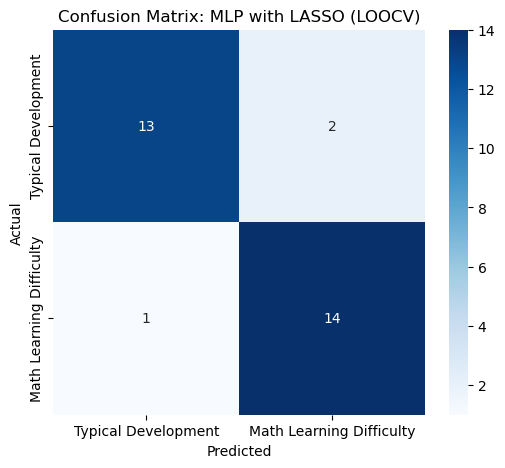

In [136]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Classification Report (Precision, Recall, F1)
# 0 = TD, 1 = MLD
target_names = ['Typical Development', 'Math Learning Difficulty']
print("\nDetailed Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

# 2. Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# 3. Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: MLP with LASSO (LOOCV)')
plt.show()

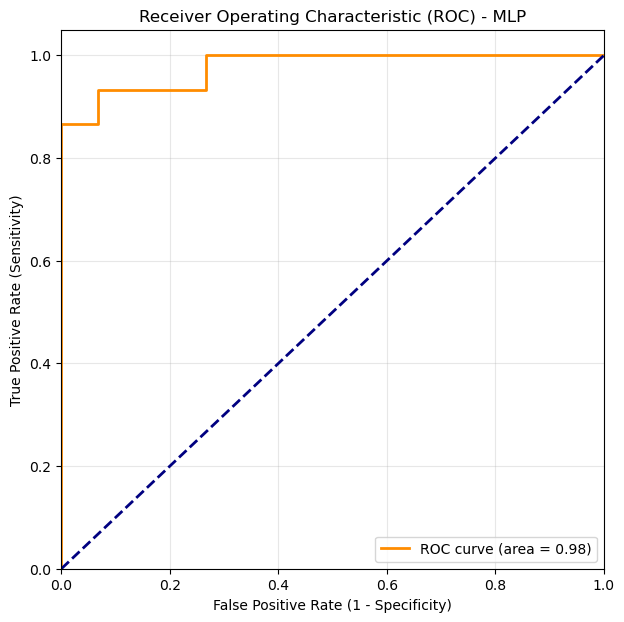

In [133]:
# 1. Convert lists to numpy arrays first
labels_array = np.array(all_test_labels)
probs_array = np.array(all_test_probs)

# 2. Flatten them to ensure they are 1D (removes that extra dimension)
labels_flat = labels_array.flatten()
probs_flat = probs_array.flatten()

from sklearn.metrics import roc_curve, auc
# After the loop finishes:
fpr, tpr, thresholds = roc_curve(labels_flat, probs_flat)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) - MLP')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [134]:
model.eval()
# Get the absolute sum of weights for each of the 100 features
# This tells us how much the model "trusts" each brain connection
feature_weights = torch.abs(model.layer1.weight).sum(dim=0).detach().numpy()

# Get indices of features with non-zero weights (the 'winners')
threshold = 1e-4 
winning_meta_indices = np.where(feature_weights > threshold)[0]
winning_raw_indices = selected_indices[winning_meta_indices]

print(f"{len(winning_raw_indices)} connections survived.")

100 connections survived.


In [135]:
from nilearn import datasets
def get_roi_names(index, n_rois=400):
    """Converts a vector index back to ROI pairs (Schaefer 400)."""
    # Create an empty upper triangle matrix
    tri_indices = np.triu_indices(n_rois, k=1)
    roi_a_idx = tri_indices[0][index]
    roi_b_idx = tri_indices[1][index]
    return roi_a_idx, roi_b_idx

# 3. Get the Top 10 Indices
# argsort gives indices of features from smallest to largest weight
# [-10:] takes the last 10 (the largest), and [::-1] puts them in descending order
top_10_meta_indices = np.argsort(feature_weights)[-10:][::-1]

# Map these meta-indices (0-99) back to the original connectivity indices (0-79799)
# Assuming 'selected_indices' is the array from your SelectKBest step
top_10_raw_indices = selected_indices[top_10_meta_indices]

# 4. Print and Store Results
print(f"--- Top 10 Connectivity Fingerprints ---")
top_connections_info = []
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
labels = atlas.labels
for i, raw_idx in enumerate(top_10_raw_indices):
    roi_a_idx, roi_b_idx = get_roi_names(raw_idx)
    
    label_a = (labels[roi_a_idx])
    label_b = (labels[roi_b_idx])
    score = feature_weights[top_10_meta_indices[i]]
    
    print(f"Rank {i+1}: Score {score:.4f} | {label_a} <-> {label_b}")
    
    top_connections_info.append({
        'rank': i+1,
        'score': score,
        'roi_a': label_a,
        'roi_b': label_b,
        'indices': (roi_a_idx, roi_b_idx)
    })

--- Top 10 Connectivity Fingerprints ---
[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018
Rank 1: Score 1.7894 | 7Networks_RH_Vis_17 <-> 7Networks_RH_Default_PFCdPFCm_12
Rank 2: Score 1.2874 | 7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8
Rank 3: Score 0.6513 | 7Networks_LH_DorsAttn_Post_1 <-> 7Networks_RH_Vis_11
Rank 4: Score 0.5957 | 7Networks_LH_Limbic_TempPole_4 <-> 7Networks_RH_Default_Par_3
Rank 5: Score 0.4957 | 7Networks_LH_Vis_25 <-> 7Networks_RH_Cont_Par_2
Rank 6: Score 0.4503 | 7Networks_RH_Vis_26 <-> 7Networks_RH_DorsAttn_Post_13
Rank 7: Score 0.4494 | 7Networks_LH_Cont_PFCl_5 <-> 7Networks_RH_Limbic_TempPole_5
Rank 8: Score 0.4421 | 7Networks_RH_SomMot_25 <-> 7Networks_RH_SalVentAttn_FrOperIns_5
Rank 9: Score 0.3895 | 7Networks_LH_SalVentAttn_Med_4 <-> 7Networks_RH_Default_Temp_2
Rank 10: Score 0.3878 | 7Networks_LH_Default_Temp_8 <-> 7Networks_RH_DorsAttn_Post_4


# MLP for Sub Tasks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Load your actual data
X_s, y_s, g_s = filter_task_data(X, y_groups, y_task, groups, task_id=1)
X_avg_s, y_avg_s = average_by_subject(X_s, y_s, g_s)


# 2. Calculate F-statistic scores for all 79,800 features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_avg_s, y_avg_s)
scores = selector.scores_

# 3. Sort scores in descending order
sorted_scores = np.sort(scores)[::-1]

# 4. Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_scores[:1000], color='blue', linewidth=2) # Look at top 1000
plt.axvline(x=100, color='red', linestyle='--', label='Proposed Cut-off (k=100)')

plt.title('Univariate Feature Scores (Schaefer 400 Atlas)', fontsize=14)
plt.xlabel('Feature Rank (Top 1000)', fontsize=12)
plt.ylabel('F-Statistic Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:
import torch
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# 1. First Filter: Select top 100 statistically significant connections
selector = SelectKBest(score_func=f_classif, k=100)
X_reduced_s = selector.fit_transform(X_avg_s, y_avg_s)
selected_indices = selector.get_support(indices=True)

# 2. Scale the data (Lasso/MLPs require this!)
scaler = StandardScaler()
X_final_s = scaler.fit_transform(X_reduced_s)

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import torch
import numpy as np

loo = LeaveOneOut()
all_test_preds = []
all_test_labels = []
all_test_probs = []

print(f"Starting LOOCV with LASSO regularization...")

for train_idx, test_idx in loo.split(X_final_s):
    # 1. Split Data
    X_train, X_test = X_final_s[train_idx], X_final_s[test_idx]
    y_train, y_test = y_avg_s[train_idx], y_avg_s[test_idx]

    # 2. Convert to Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)

    # 3. Initialize fresh model and optimizer for THIS fold
    model = LassoBrainMLP() # Your 100 -> 32 -> 1 model
    criterion = torch.nn.BCELoss() # The BCE Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    l1_lambda = 0.005 

    # 4. Train on the 29 participants
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        
        # Calculate BCE Loss
        bce_loss = criterion(outputs, y_train_t)
        
        # Add LASSO Penalty
        l1_penalty = torch.norm(model.layer1.weight, 1)
        total_loss = bce_loss + (l1_lambda * l1_penalty)
        
        total_loss.backward()
        optimizer.step()

    # 5. Test on the 1 participant left out
    model.eval()
    with torch.no_grad():
        test_prob = model(X_test_t)
        all_test_probs.append(test_prob)
        # Convert probability to 0 or 1
        test_pred = 1.0 if test_prob.item() > 0.5 else 0.0
        
        all_test_preds.append(test_pred)
        all_test_labels.append(y_test[0])

# 6. Final Report
final_acc = accuracy_score(all_test_labels, all_test_preds)
print(f"\nFinal LOOCV Accuracy: {final_acc * 100:.2f}%")